In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image

import sklearn.metrics
import skimage.segmentation
from skimage.segmentation import mark_boundaries
from tqdm.auto import tqdm
from sklearn.linear_model import Lasso, Ridge


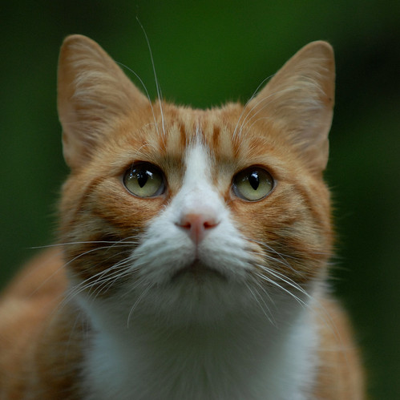

In [2]:
cat = Image.open("cat.jpg")
cat.resize((400, 400))


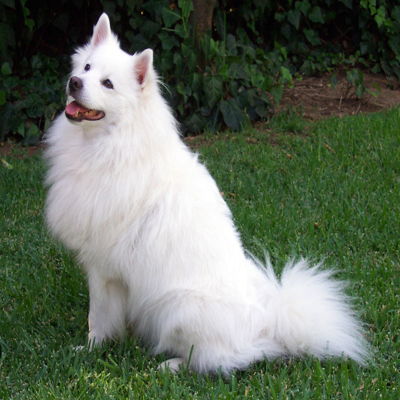

In [3]:
dog = Image.open("dog2.jpg")
dog.resize((400, 400))

In [5]:
# Download ImageNet labels
!wget -q "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
!head "imagenet_classes.txt"

tench
goldfish
great white shark
tiger shark
hammerhead
electric ray
stingray
cock
hen
ostrich


In [6]:
from dataclasses import dataclass

@dataclass
class ImageLabel:
    name: str
    id: int
    probability: float

    def __repr__(self):
        return f"{self.name}({self.id}): {self.probability}"

class Predictor():
    def __init__(self):
        # Read the categories
        with open("imagenet_classes.txt", "r") as f:
            self.categories = [s.strip() for s in f.readlines()]
        
        self.model = torchvision.models.inception_v3(pretrained=True, progress=False)
        self.model.eval()


    def predict_prob(self, img):
        preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(img)

        # create a mini-batch as expected by the model
        input_batch = input_tensor.unsqueeze(0)
        with torch.no_grad():
            output = self.model(input_batch)

        # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
        return torch.nn.functional.softmax(output[0], dim=0)

    def predict_labels(self, img, topk=5):
        result = []
        probabilities = self.predict_prob(img)

        topk_prob, topk_labels = torch.topk(probabilities, topk)
        for prob, label_id in zip(topk_prob, topk_labels):
            result.append(ImageLabel(self.categories[label_id], label_id.item(), prob.item()))

        return result


In [7]:
predictor = Predictor()

predictor.predict_labels(cat)

[tiger cat(282): 0.4298544228076935,
 tabby(281): 0.3083222508430481,
 Egyptian cat(285): 0.17298807203769684,
 plastic bag(728): 0.007332428824156523,
 Siamese cat(284): 0.002987136133015156]

In [8]:
predictor.predict_labels(dog)

[Samoyed(258): 0.8238474130630493,
 Arctic fox(279): 0.014191566035151482,
 white wolf(270): 0.01230349950492382,
 Pomeranian(259): 0.00787467509508133,
 keeshond(261): 0.006387809757143259]

In [9]:
def show_images(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fix.set_figheight(20)
    fix.set_figwidth(20)

    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [10]:
def get_segments(image):
    return skimage.segmentation.slic(image, n_segments=250, compactness=10, sigma=1, start_label=1)

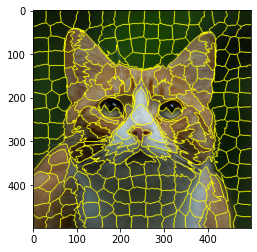

In [11]:
segments = get_segments(cat)
plt.imshow(mark_boundaries(cat, segments))


In [12]:
def generate_perturbations(image, num_samples):
    segments = get_segments(image)
    
    n_features = len(np.unique(segments))

    # data is a matrix where each row is an instance and each feature is a bool that indicates whether the i'th segment is turned on or off
    data = np.random.randint(0, 2, num_samples * n_features).reshape((num_samples, n_features))
    data[0, :] = 1 # Set the first instance to be the original image
    
    imgs = []

    for row in tqdm(data):
        temp_img = np.array(image.copy())
        zeros = np.where(row == 0)[0]
        mask = np.zeros(segments.shape).astype(bool)
        for z in zeros:
            mask[segments == z] = True

        temp_img[mask] = 0 
        imgs.append(temp_img)

    return np.array(imgs), data



100%|██████████| 500/500 [00:07<00:00, 62.96it/s]


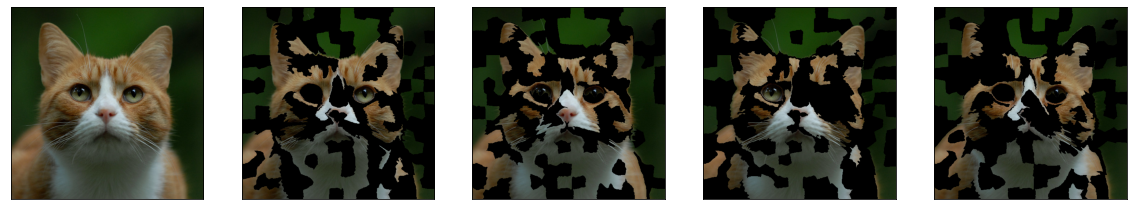

In [14]:
random_cats_images, neighborhood_data = generate_perturbations(cat, 500)
show_images(random_cats_images[:5])

In [15]:
def exp_kernel(d, sigma):
    return np.sqrt(np.exp(-(d ** 2) / sigma ** 2))

def get_proximity_weights(neighborhood_data):
    distances = sklearn.metrics.pairwise_distances(
        neighborhood_data,
        [neighborhood_data[0]],
        metric='cosine'
    ).ravel()

    proximity_weights = np.array([exp_kernel(d, 0.25) for d in distances])
    return proximity_weights

In [16]:
proximity_weights = get_proximity_weights(neighborhood_data)
proximity_weights

array([1.        , 0.56202044, 0.62281255, 0.49305391, 0.51381883,
       0.44465277, 0.47920507, 0.50690033, 0.44465277, 0.4515491 ,
       0.52763887, 0.50690033, 0.50690033, 0.54142632, 0.4515491 ,
       0.54142632, 0.57567478, 0.47920507, 0.53453741, 0.50690033,
       0.52073218, 0.49305391, 0.51381883, 0.47920507, 0.57567478,
       0.57567478, 0.48612903, 0.55516929, 0.49305391, 0.57567478,
       0.52763887, 0.4515491 , 0.47228356, 0.46536604, 0.44465277,
       0.49997818, 0.4308921 , 0.41035424, 0.49305391, 0.5483041 ,
       0.47920507, 0.48612903, 0.50690033, 0.45845404, 0.52073218,
       0.5483041 , 0.56885608, 0.50690033, 0.56202044, 0.55516929,
       0.6027517 , 0.54142632, 0.59601496, 0.5824751 , 0.47920507,
       0.5483041 , 0.55516929, 0.65566891, 0.55516929, 0.52763887,
       0.5483041 , 0.49997818, 0.49305391, 0.56202044, 0.52073218,
       0.52073218, 0.47228356, 0.52763887, 0.43776659, 0.47228356,
       0.57567478, 0.44465277, 0.49997818, 0.47228356, 0.60275

In [17]:
def get_labels_probabilities(images):
    neighborhood_labels = []
    for img in tqdm(images):
        predicted_labels = predictor.predict_prob(Image.fromarray(img))
        neighborhood_labels.append(np.array(predicted_labels))

    return np.array(neighborhood_labels)

In [18]:
# Get the labels for all the neighborhood
neighborhood_labels = get_labels_probabilities(random_cats_images)
neighborhood_labels.shape

100%|██████████| 500/500 [00:37<00:00, 13.37it/s]


(500, 1000)

In [19]:
predictor.predict_labels(cat)

[tiger cat(282): 0.4298544228076935,
 tabby(281): 0.3083222508430481,
 Egyptian cat(285): 0.17298807203769684,
 plastic bag(728): 0.007332428824156523,
 Siamese cat(284): 0.002987136133015156]

In [20]:
explain_label = 282

In [21]:
linear_model = Ridge()
linear_model.fit(X=neighborhood_data,
                    y=neighborhood_labels[:, explain_label],
                    sample_weight=proximity_weights)


Ridge()

In [22]:
linear_model.score(X=neighborhood_data,
                   y=neighborhood_labels[:, explain_label],
                   sample_weight=proximity_weights)

0.6424003026452196

In [23]:
linear_model.predict(X=neighborhood_data[0, :].reshape(1, -1))

array([0.35095612])

In [24]:
neighborhood_labels[0, explain_label]

0.42985442

In [25]:
def get_important_segments(image, model):
    segments = get_segments(image)

    segments_importance = sorted(
        zip(np.unique(segments), model.coef_), key=lambda x: abs(x[1]), reverse=True)
        
    return segments_importance, segments


In [26]:
def show_top_segments(image, model, topk=80):
    segments_importance, segments = get_important_segments(image, model)
    top_segments = [s[0] for s in segments_importance[:topk]]

    img_temp = np.array(image.copy())

    for segment in np.unique(segments):
        if segment not in top_segments:
            img_temp[segments == segment] = 0

    return Image.fromarray(img_temp)


In [27]:
get_important_segments(cat, linear_model)[0][:10]

[(90, 0.01801386536966555),
 (43, 0.015893437425673694),
 (73, 0.015467200614818686),
 (53, 0.014827816000741572),
 (125, 0.014735620117571421),
 (129, -0.014125933530542131),
 (55, 0.01353581324993962),
 (127, 0.013344659431005728),
 (28, 0.012928114705771062),
 (154, 0.012717097422790109)]

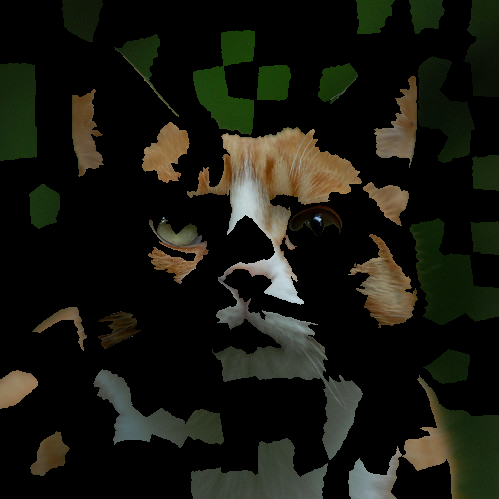

In [28]:
show_top_segments(cat, linear_model, topk=80)

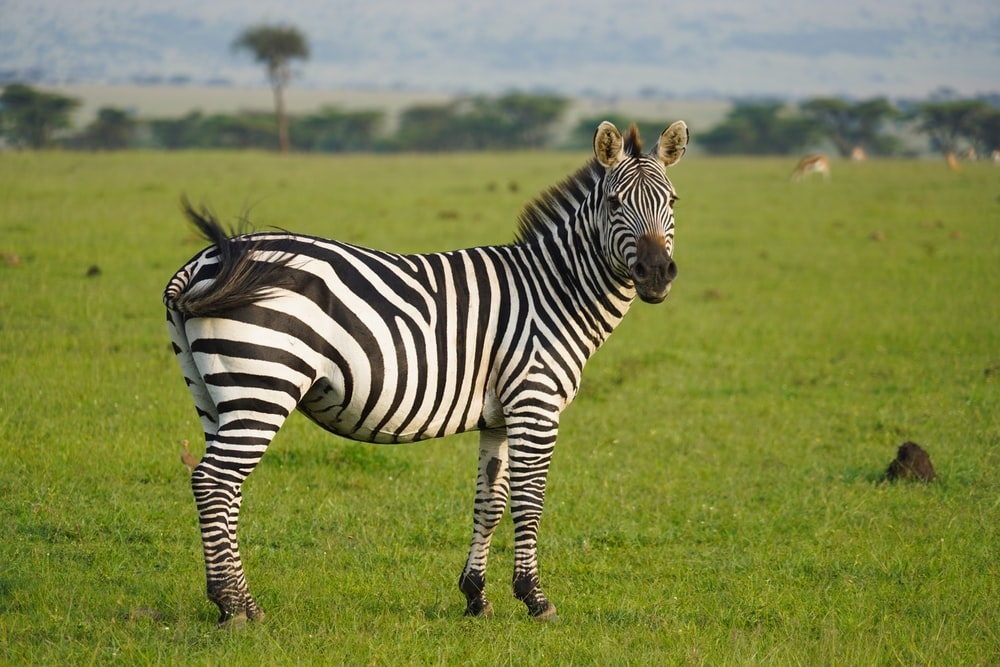

In [38]:
image2 = Image.open("zebra.jpeg")
# image2 = image2.resize((500, 400))
image2

In [39]:
predictor.predict_labels(image2)

[zebra(340): 0.9463093280792236,
 ostrich(9): 0.000965009443461895,
 hartebeest(351): 0.000855785037856549,
 Arabian camel(354): 0.00040647247806191444,
 warthog(343): 0.00032430433202534914]

In [50]:
neighborhood_images, neighborhood_data = generate_perturbations(image2, 500)
neighborhood_images.shape, neighborhood_data.shape

100%|██████████| 500/500 [00:23<00:00, 21.12it/s]


((500, 667, 1000, 3), (500, 201))

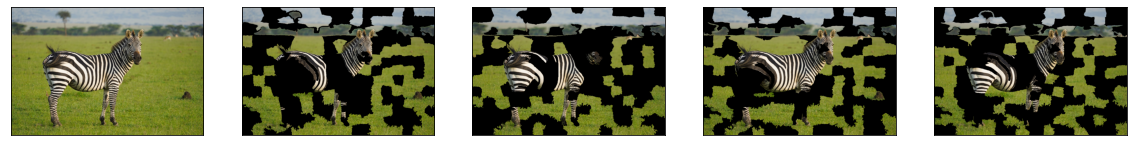

In [41]:
show_images(neighborhood_images[:5])

In [51]:
# Calculate distances
proximity_weights = get_proximity_weights(neighborhood_data)

In [52]:
# Get the labels for all the neighborhood
neighborhood_labels = get_labels_probabilities(neighborhood_images)
neighborhood_labels.shape

100%|██████████| 500/500 [00:41<00:00, 12.18it/s]


(500, 1000)

In [53]:
explain_label = 340

In [54]:
linear_model = Ridge()
linear_model.fit(X=neighborhood_data,
                 y=neighborhood_labels[:, explain_label],
                 sample_weight=proximity_weights)


Ridge()

In [55]:
# Show the R^2 score:
linear_model.score(X=neighborhood_data,
                   y=neighborhood_labels[:, explain_label],
                   sample_weight=proximity_weights)


0.5373341480325823

In [56]:
# The predicted probability for the original image
linear_model.predict(X=neighborhood_data[0, :].reshape(1, -1))[0]


1.0356727473840128

In [57]:
segments_importance = get_important_segments(image2, linear_model)[0]
segments_importance[:10]


[(49, 0.07109167435334052),
 (99, 0.0502683346726061),
 (24, -0.050092136276807746),
 (114, 0.045818158249437434),
 (116, 0.04501804024202201),
 (72, 0.044128789246020574),
 (46, 0.04295035795116828),
 (19, -0.040628592429620615),
 (76, 0.03934143127219359),
 (129, 0.03695226799750932)]

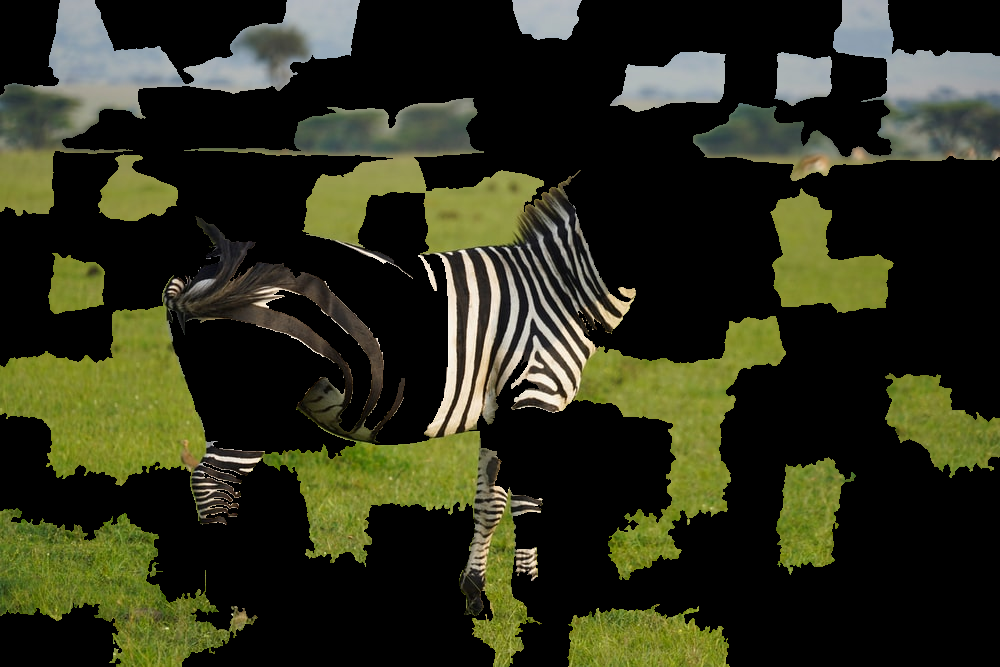

In [58]:
show_top_segments(image2, linear_model, topk=70)

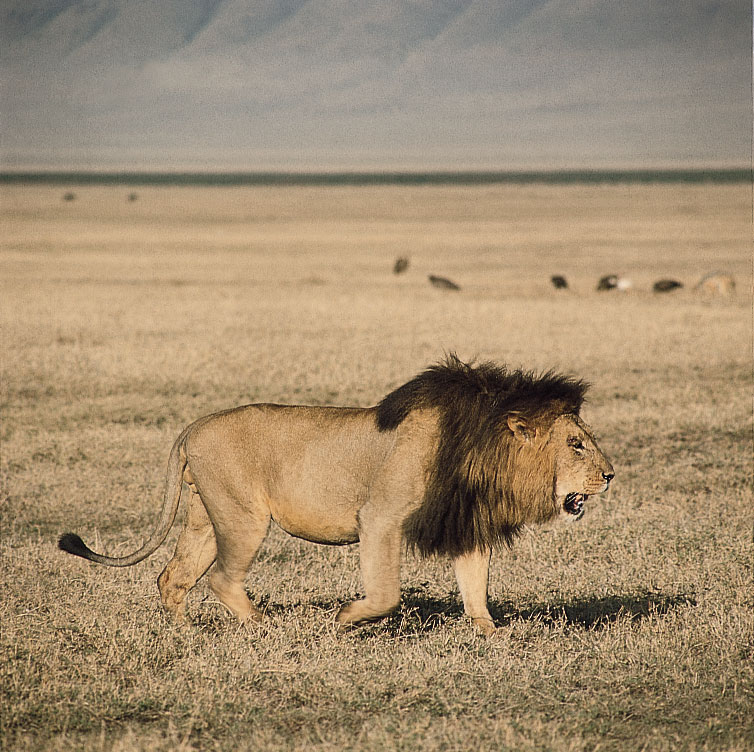

In [61]:
lion = Image.open("lion2.jpg")
lion

In [62]:
predictor.predict_labels(lion)


[lion(291): 0.9861607551574707,
 chow(260): 0.00034211986348964274,
 Arabian camel(354): 0.00028660849784500897,
 warthog(343): 0.00025742113939486444,
 hyena(276): 0.0002555021783336997]

In [64]:
neighborhood_images, neighborhood_data = generate_perturbations(lion, 500)
neighborhood_images.shape, neighborhood_data.shape

100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


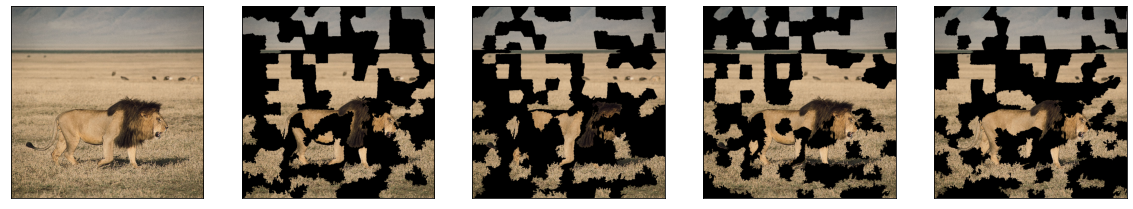

In [69]:
show_images(neighborhood_images[:5])


In [65]:
proximity_weights = get_proximity_weights(neighborhood_data)
neighborhood_labels = get_labels_probabilities(neighborhood_images)
neighborhood_labels.shape


100%|██████████| 500/500 [00:44<00:00, 11.29it/s]


(500, 1000)

In [70]:
explain_label = 291

linear_model = Ridge()
linear_model.fit(X=neighborhood_data,
                 y=neighborhood_labels[:, explain_label],
                 sample_weight=proximity_weights)


Ridge()

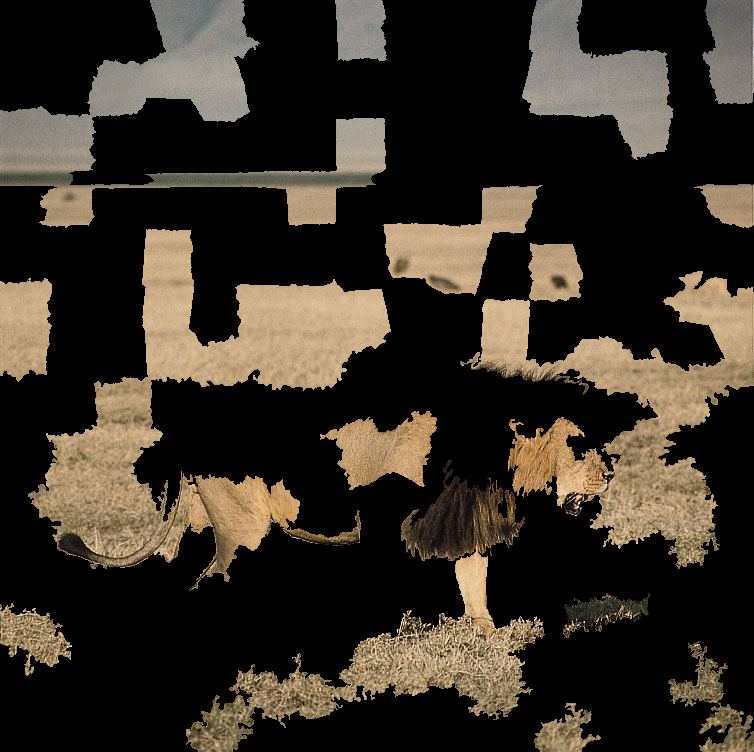

In [71]:
show_top_segments(lion, linear_model, topk=70)
